### Follow up

This is a follow up from previous experiment with feedforward neural network. Here we repeat the classification problem and restrict to classification with two (instead of three) models. Using an appropriately tuned deep convolutional neural network to train a set of synthetically generated data ($1333$ training examples, with each example consisting of a time series/trajectory for the $x$-coordinate of 102 steps), we found that accuracy on the test data ($667$ test examples, with each example consisting of a trajectory for the $x$-coordinate of 102 steps) is around $100 \%$, showing that this perfect accuracy is possible for at least a specialized setting of the problem.   

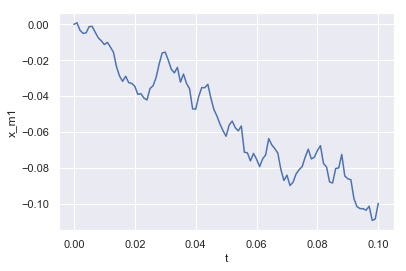

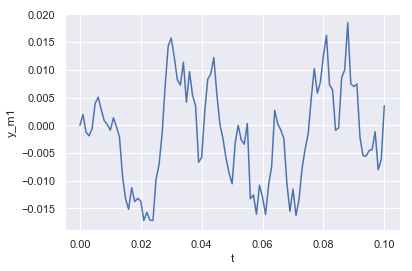

In [22]:
#Model 0 -- ABM
import numpy as np
import matplotlib.pyplot as plt
import sdeint
import math
np.random.seed(100)

# To display plots directly in the notebook:
%matplotlib inline

import pandas as pd
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

#universal parameters for all models
D_T=0.01
k=0.5

#number of simulations/training trajs for each model
M=1000


##########################################
#model-specific parameters
#Active BM -- self-propelled, +non-Gaussian noise
v0=np.random.uniform(0.5,1,1)
D_R=np.random.uniform(0.1,0.2,1)

#drift and noise coefficient
def f(x,t):
    f0=v0*np.cos(x[2])-k*x[0] 
    f1=v0*np.sin(x[2])-k*x[1]
    f2=0
    return np.array([f0,f1,f2])
    
def g(x,t):
    g0=np.sqrt(2*D_T)
    g1=g0
    g2=np.sqrt(2*D_R)
    return np.array([g0, g1, g2]).reshape((3,1))

#initial conditions
x0=0.0; x1=0.0; x2=np.random.uniform(0,2*math.pi,1)

T=0.1; N=100; dt=T/N  #play with these

t=np.linspace(0,T,N+1) #vector of N dims
xzero = np.array([x0, x1, x2])

x_m1 = [sdeint.itoint(f, g, xzero, t) for _ in range(M)]
x_m1 = np.array(x_m1)

plt.plot(t, x_m1[0,:,0])
plt.xlabel('t')
plt.ylabel('x_m1')
plt.show()
plt.plot(t,x_m1[0,:,1])
plt.xlabel('t')
plt.ylabel('y_m1')
plt.show()

np.savetxt('trajx_m0_bin.csv', np.c_[np.insert(x_m1[:,:,0], N+1, 0, axis=1)], delimiter=',')    #save M number of x-variable trajectories over N+1 discretized grids
np.savetxt('trajy_m0_bin.csv', np.c_[np.insert(x_m1[:,:,1], N+1, 0, axis=1)], delimiter=',')    #save M number of y-variable trajectories over N+1 discretized grids



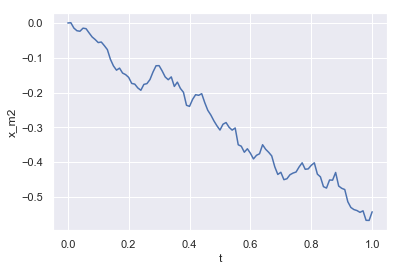

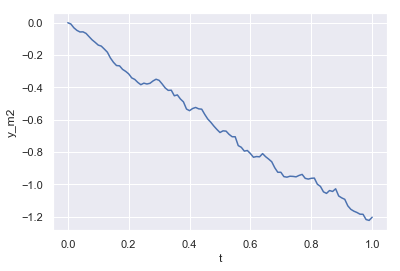

In [23]:
#Model 1 -- AUP
import numpy as np
import matplotlib.pyplot as plt
import sdeint
import math
np.random.seed(100)

import pandas as pd
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

#universal parameters for all models
D_T=0.01
k=0.5

#number of simulations/training trajs for each model
M=1000

#model-specific parameters
#Active OUP --- +(indep) OU process
v0=np.random.uniform(0.5,1,1)
alpha=0.1 #np.random.uniform(0.1,0.2,1)
D_A=alpha
#np.random.uniform(0.1,0.2,1)

#drift and noise coefficient
def f(x,t):
    f0=v0*x[2]-k*x[0] 
    f1=v0*x[3]-k*x[1]
    f2=-alpha*x[2]
    f3=f2
    return np.array([f0,f1,f2,f3])
    
def g(x,t):
    g0=np.sqrt(2*D_T)
    g1=g0
    g2=np.sqrt(2*D_A)
    g3=g2
    return np.array([g0, g1, g2, g3]).reshape((4,1))

#initial conditions
x0=0.0; x1=0.0; x2=np.sqrt(D_A/alpha)*np.random.randn(); x3=np.sqrt(D_A/alpha)*np.random.randn() 

T=1; N=100; dt=T/N 
t=np.linspace(0,T,N+1) #vector of N dims
xzero = np.array([x0, x1, x2, x3])

x_m2 = [sdeint.itoint(f, g, xzero, t) for _ in range(M)]
x_m2 = np.array(x_m2)

plt.plot(t, x_m2[0,:,0])
plt.xlabel('t')
plt.ylabel('x_m2')
plt.show()
plt.plot(t,x_m2[0,:,1])
plt.xlabel('t')
plt.ylabel('y_m2')
plt.show()

np.savetxt('trajx_m1_bin.csv', np.c_[np.insert(x_m2[:,:,0], N+1, 1, axis=1)], delimiter=',')    #save M number of x-variable trajectories over N+1 discretized grids
np.savetxt('trajy_m1_bin.csv', np.c_[np.insert(x_m2[:,:,1], N+1, 1, axis=1)], delimiter=',')    #save M number of y-variable trajectories over N+1 discretized grids


In [24]:
#Binary classification: Gaussian vs non-Gaussian driving noise (i.e. Model 0 or Model 1)

from keras import layers
from keras import models
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import pandas as pd

#number of categories
num_classes = 2  

model=models.Sequential()
model.add(layers.Conv1D(32,6,activation='relu',input_shape=(101,1),))
model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(64,6,activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128,6,activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256,6,activation='relu'))
model.add(layers.MaxPooling1D(2))
#adding a classifier on top of convnet
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256*2,activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 96, 32)            224       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 43, 64)            12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 21, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 16, 128)           49280     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 3, 256)            196864    
__________

In [26]:
# First, we get the data
dataset0 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m0_bin.csv",header=None)
dataset1 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m1_bin.csv",header=None)
#dataset2 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m2.csv",header=None)

li = []
li.append(dataset0)
li.append(dataset1)

dataset = np.array(pd.concat(li, axis=0, ignore_index=True))
np.random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

np.savetxt('all_traj.csv', np.c_[dataset], delimiter=',') 

dataset.head(10)
row=np.shape(dataset)[0]
col=np.shape(dataset)[1]
print(row); print(col)

# Checking for missing values
num_train = int(row*2/3)
training_set = dataset[:num_train].iloc[:,0:col].values
test_set = dataset[num_train:].iloc[:,0:col].values
print(np.shape(training_set)); print(np.shape(test_set))

training_df = pd.DataFrame(training_set)
training_df.head(10)

#pd.plotting.scatter_matrix(training_df, c=training_set['750'], figsize=(15,15), marker='o', s=60)
#plt.show()

2000
102
(1333, 102)
(667, 102)


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.0,-0.031757,-0.039446,-0.038395,-0.045057,-0.043813,-0.020987,-0.022295,-0.031598,-0.048889,...,-0.339012,-0.327022,-0.328897,-0.321412,-0.323982,-0.347681,-0.350695,-0.354060,-0.336640,1.0
1,0.0,-0.017307,-0.030665,-0.019818,-0.028128,-0.033442,-0.029967,-0.049397,-0.095216,-0.096405,...,-0.579923,-0.607193,-0.591960,-0.605384,-0.628520,-0.622251,-0.650033,-0.631462,-0.643707,1.0
2,0.0,-0.004761,-0.005204,-0.003701,-0.007395,-0.008626,-0.007040,-0.000414,0.001399,0.005107,...,-0.046209,-0.049548,-0.041935,-0.041985,-0.039138,-0.041495,-0.047845,-0.052754,-0.051709,0.0
3,0.0,-0.011505,-0.016812,0.008328,0.024058,0.026425,0.021449,0.015874,0.049020,0.049535,...,0.163777,0.127690,0.118085,0.136624,0.141445,0.144243,0.126317,0.134131,0.104724,1.0
4,0.0,-0.013820,-0.021921,-0.032931,-0.059845,-0.043686,-0.058996,-0.073821,-0.109035,-0.110399,...,-0.406021,-0.417146,-0.413008,-0.402274,-0.433208,-0.425060,-0.435945,-0.453193,-0.471950,1.0
5,0.0,-0.002396,-0.010623,-0.006165,-0.008567,-0.009162,-0.009096,-0.008069,-0.015631,-0.010899,...,-0.078536,-0.084739,-0.080491,-0.085045,-0.087052,-0.096700,-0.091768,-0.087699,-0.081974,0.0
6,0.0,-0.022117,-0.012454,-0.026293,-0.032216,-0.030544,-0.007108,-0.009506,-0.021497,-0.023134,...,-0.395728,-0.381839,-0.391935,-0.389780,-0.398628,-0.386941,-0.367563,-0.364375,-0.371378,1.0
7,0.0,0.004032,-0.006560,0.000737,0.004688,0.010770,0.013880,0.007436,0.005562,0.009399,...,0.017145,0.011571,0.009384,0.004058,-0.000166,-0.003080,-0.000083,0.001591,0.001886,0.0
8,0.0,-0.010624,-0.005574,-0.012494,-0.027559,-0.013745,-0.027381,-0.009352,0.001472,-0.038017,...,-0.169801,-0.187653,-0.200844,-0.217431,-0.229203,-0.242945,-0.245688,-0.251616,-0.220302,1.0
9,0.0,-0.021837,-0.056747,-0.042965,-0.041839,-0.062540,-0.062623,-0.053232,-0.074323,-0.071283,...,-0.546705,-0.539941,-0.522854,-0.529078,-0.536393,-0.546165,-0.561617,-0.554327,-0.564175,1.0


In [27]:
# the data, split between train and test sets
x_train=training_set[:,:col-1]
y_train=training_set[:,col-1:]
x_test=test_set[:,:col-1]
y_test2=test_set[:,col-1:]

x_train = x_train.reshape(num_train, col-1)
x_test = x_test.reshape(row-num_train, col-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(np.shape(x_train)); print(np.shape(x_test))
print(np.shape(y_train)); print(np.shape(y_test))

1333 train samples
667 test samples
(1333, 101)
(667, 101)
(1333, 1)
(667, 2)


In [28]:
from keras.utils import to_categorical

x_train=x_train.reshape((num_train,col-1,1))
x_train=x_train.astype('float32')

x_test=x_test.reshape((row-num_train,col-1,1))
x_test=x_test.astype('float32')

y_train=to_categorical(y_train)
y_test=to_categorical(y_test2)

In [29]:
#hyperparameters
epochs=100
batch_size=500

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1333 samples, validate on 667 samples
Epoch 1/100
1333/1333 [==============================] - 4s 3ms/step - loss: 0.6462 - acc: 0.4929 - val_loss: 0.4588 - val_acc: 0.9085
Epoch 2/100
1333/1333 [==============================] - 2s 1ms/step - loss: 0.5513 - acc: 0.7764 - val_loss: 0.4102 - val_acc: 0.9340
Epoch 3/100
1333/1333 [==============================] - 2s 1ms/step - loss: 0.3819 - acc: 0.9167 - val_loss: 0.2857 - val_acc: 0.9385
Epoch 4/100
1333/1333 [==============================] - 1s 997us/step - loss: 0.2665 - acc: 0.9197 - val_loss: 0.2714 - val_acc: 0.8891
Epoch 5/100
1333/1333 [==============================] - 1s 782us/step - loss: 0.3228 - acc: 0.8672 - val_loss: 0.2292 - val_acc: 0.9145
Epoch 6/100
1333/1333 [==============================] - 1s 873us/step - loss: 0.2250 - acc: 0.9212 - val_loss: 0.1641 - val_acc: 0.9430
Epoch 7/100
1333/1333 [==============================] - 1s 919us/step - loss: 0.1747 - acc: 0.9362 - val_loss: 0.2432 - val_acc: 0.9175


In [30]:
test_loss, test_acc=model.evaluate(x_test,y_test)
test_acc

667/667 [==============================] - 0s 307us/step


1.0

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


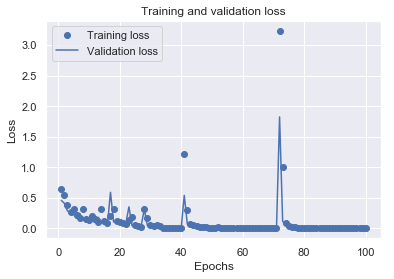

In [31]:
history_dict = history.history
print(history_dict.keys())
#plotting the training and validation loss
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss') #bo for blue dot
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

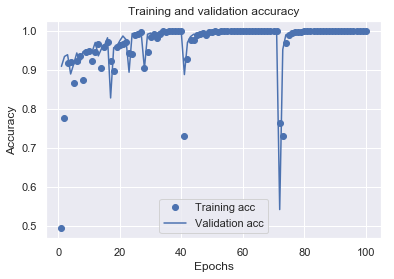

In [32]:
plt.clf()
acc=history_dict['acc']
val_acc=history_dict['val_acc']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
import numpy as np
classes = model.predict(x_test)
M = np.argmax(classes, axis=1)
predict = np.asarray(M).reshape(-1)
actual = np.asarray(y_test2).reshape(-1)
np.sum(predict==actual)/(row-num_train) #test_accuracy

from sklearn.metrics import confusion_matrix
confusion_matrix(actual,predict)

array([[339,   0],
       [  0, 328]], dtype=int64)